# pyiron_base

https://github.com/BAMresearch/NFDI4IngScientificWorkflowRequirements

## Define workflow with pyiron_base

In [1]:
import os

In [2]:
from workflow import (
    generate_mesh as _generate_mesh, 
    convert_to_xdmf as _convert_to_xdmf,
    poisson as _poisson,
    plot_over_line as _plot_over_line,
    substitute_macros as _substitute_macros,
    compile_paper as _compile_paper,
)

In [3]:
from pyiron_base import job

from python_workflow_definition.pyiron_base import write_workflow_json

In [4]:
generate_mesh = job(_generate_mesh)
convert_to_xdmf = job(_convert_to_xdmf, output_key_lst=["xdmf_file", "h5_file"])
poisson = job(_poisson, output_key_lst=["numdofs", "pvd_file", "vtu_file"])
plot_over_line = job(_plot_over_line)
substitute_macros = job(_substitute_macros)
compile_paper = job(_compile_paper)

In [5]:
domain_size = 2.0

In [6]:
source_directory = os.path.abspath(os.path.join(os.curdir, "source"))

In [7]:
gmsh_output_file = generate_mesh(
    domain_size=domain_size,
    source_directory=source_directory,
)

In [8]:
meshio_output_dict = convert_to_xdmf(
    gmsh_output_file=gmsh_output_file,
)

In [9]:
poisson_dict = poisson(
    meshio_output_xdmf=meshio_output_dict.output.xdmf_file, 
    meshio_output_h5=meshio_output_dict.output.h5_file,
    source_directory=source_directory,
)

In [10]:
pvbatch_output_file = plot_over_line(
    poisson_output_pvd_file=poisson_dict.output.pvd_file, 
    poisson_output_vtu_file=poisson_dict.output.vtu_file,
    source_directory=source_directory,
)

In [11]:
macros_tex_file = substitute_macros( 
    pvbatch_output_file=pvbatch_output_file, 
    ndofs=poisson_dict.output.numdofs, 
    domain_size=domain_size,
    source_directory=source_directory,
)

In [12]:
paper_output = compile_paper(
    macros_tex=macros_tex_file, 
    plot_file=pvbatch_output_file,
    source_directory=source_directory,
)

In [13]:
workflow_json_filename = "pyiron_base_nfdi.json"

In [14]:
write_workflow_json(delayed_object=paper_output, file_name=workflow_json_filename)

## Load Workflow with pyiron_workflow

In [15]:
from python_workflow_definition.pyiron_workflow import load_workflow_json

In [16]:
wf = load_workflow_json(file_name=workflow_json_filename)

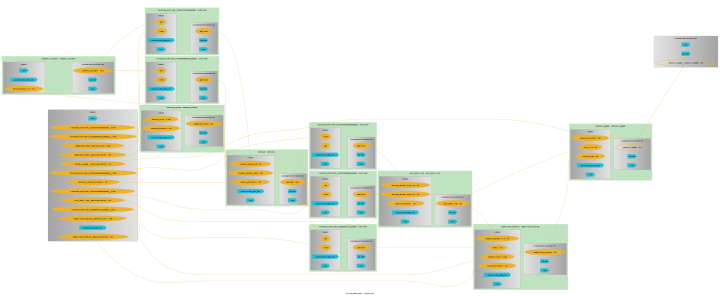

In [17]:
wf.draw(size=(10,10))

In [18]:
wf.run()

/srv/conda/envs/notebook/envs/processing/lib/python3.9/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


{'compile_paper__compile_paper': '/home/jovyan/postprocessing/paper.pdf'}

## Load Workflow with executorlib

In [19]:
from executorlib import SingleNodeExecutor

In [20]:
from python_workflow_definition.executorlib import load_workflow_json

In [21]:
with SingleNodeExecutor(max_workers=1) as exe:
    result = load_workflow_json(file_name=workflow_json_filename, exe=exe).result()

/srv/conda/envs/notebook/envs/processing/lib/python3.9/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [22]:
result

'/home/jovyan/postprocessing/paper.pdf'